## AST Generation

### Example AST: Hello, world 

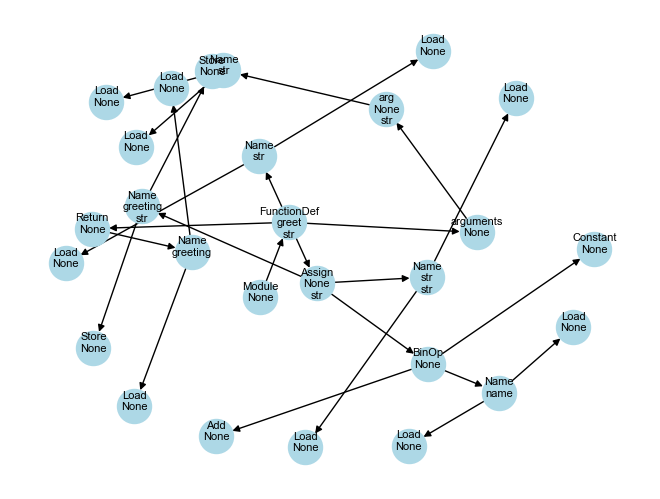

In [1]:
from utils.graph_extractor import GraphExtractor
import ast
import os
import torch
import torch_geometric

import matplotlib.pyplot as plt
import networkx as nx

code_with_annotations = """
def greet(name: str) -> str:
    greeting: str = 'Hello, ' + name
    return greeting
"""
parsed_ast_with_annotations = ast.parse(code_with_annotations)

extracted_graph = GraphExtractor()
extracted_graph.visit(parsed_ast_with_annotations)

extracted_nodes, extracted_edges, extracted_labels, extracted_names = (
    extracted_graph.nodes,
    extracted_graph.edges,
    extracted_graph.labels,
    extracted_graph.names
)

source_nodes, target_nodes = zip(*extracted_edges)

source_nodes_list = list(source_nodes)
target_nodes_list = list(target_nodes)

x = torch.tensor([extracted_nodes.index(node) for node in extracted_nodes], dtype=torch.long)

data = torch_geometric.data.Data(x=x, edge_index=torch.tensor([source_nodes_list, target_nodes_list]))
g = torch_geometric.utils.to_networkx(data, to_undirected=False)

pos = nx.spring_layout(g, k=0.7)

nx.draw(g, pos, with_labels=False, node_color='lightblue', font_weight='bold', node_size=600)
node_labels = {i: "{}\n{}\n{}".format(label, extracted_names[i], extracted_labels[i] or '') for i, label in enumerate(extracted_nodes)}
nx.draw_networkx_labels(g, pos, labels=node_labels, font_size=8)
plt.show()


### Parsing repos into a dataset

In [ ]:
from utils.data_parser import parse_python_files_in_directories

directories = [ os.getcwd() + '/data/repos/' + d for d in os.listdir(os.getcwd() + '/data/repos/') if os.path.isdir(os.getcwd() + '/data/repos/' + d) ]
results = parse_python_files_in_directories(directories)

results

Unicode decode error encountered in file E:\PWr\gnn-projekt\Notebook/data/repos/FlagEmbedding\examples\search_demo\run.py
Unicode decode error encountered in file E:\PWr\gnn-projekt\Notebook/data/repos/FlagEmbedding\examples\search_demo\tool.py
Unicode decode error encountered in file E:\PWr\gnn-projekt\Notebook/data/repos/myoddweb.piger\monitor\api\python\Python-3.7.2\Lib\sqlite3\test\dbapi.py
Unicode decode error encountered in file E:\PWr\gnn-projekt\Notebook/data/repos/myoddweb.piger\monitor\api\python\Python-3.7.2\Lib\sqlite3\test\factory.py
Unicode decode error encountered in file E:\PWr\gnn-projekt\Notebook/data/repos/myoddweb.piger\monitor\api\python\Python-3.7.2\Lib\sqlite3\test\hooks.py
Unicode decode error encountered in file E:\PWr\gnn-projekt\Notebook/data/repos/myoddweb.piger\monitor\api\python\Python-3.7.2\Lib\sqlite3\test\regression.py
Unicode decode error encountered in file E:\PWr\gnn-projekt\Notebook/data/repos/myoddweb.piger\monitor\api\python\Python-3.7.2\Lib\sqlit

### Parsing data (not memory efficient)

In [3]:
counted_map_of_labels = {}
for result in results.values():
    for label in result['labels']:
        if label:
            if label in counted_map_of_labels:
                counted_map_of_labels[label] += 1
            else:
                counted_map_of_labels[label] = 1
num_classes = len(set(label for result in results.values() for label in result['labels'] if label))
print(f"Number of classes: {num_classes}")

sorted_map_of_labels = {k: v for k, v in sorted(counted_map_of_labels.items(), key=lambda item: item[1], reverse=True)}
sorted_map_of_labels

Number of classes: 5527


{'str': 11956,
 'int': 8734,
 'bool': 7734,
 'Optional[bool]': 5072,
 'Optional[str]': 3465,
 'Optional[torch.Tensor]': 2654,
 'BinOp': 2613,
 'torch.Tensor': 2459,
 'Optional[int]': 2277,
 'Optional[torch.FloatTensor]': 2096,
 'float': 2025,
 'Any': 1840,
 'tf.Tensor': 1349,
 'Optional[torch.LongTensor]': 1336,
 'List[str]': 1146,
 'torch.FloatTensor': 962,
 'List[int]': 814,
 'Dict': 781,
 'Dict[(str, Any)]': 744,
 'Optional[Tuple[torch.FloatTensor]]': 721,
 'dict': 595,
 'Optional[float]': 580,
 'np.ndarray': 576,
 'commands.Context': 532,
 'TensorType': 394,
 'Optional[List[int]]': 363,
 'jnp.dtype': 318,
 'Optional[Union[(str, ChannelDimension)]]': 306,
 'torch.LongTensor': 303,
 'Path': 285,
 'Optional[Dict[(str, Any)]]': 279,
 'Dict[(str, str)]': 269,
 'Dict[(str, int)]': 265,
 'Optional[Tuple[Tuple[torch.FloatTensor]]]': 248,
 'Tensor': 234,
 'jnp.ndarray': 233,
 'SampleBatch': 220,
 'Optional[List[str]]': 214,
 'Optional[Dict]': 214,
 'list': 193,
 'Tuple[(int, int)]': 190,
 '

In [4]:
datas = []
all_labels = [ label for result in results.values() for label in result['labels'] if label]
all_labels_set = set(all_labels)
all_labels_uniques = list(all_labels_set)
all_labels_indices = [ all_labels_uniques.index(label) for label in all_labels ]
all_labels_indices_map = { label: all_labels_uniques.index(label) + 1 for label in all_labels_set }

for result in results.values():
    nodes, edge_starts, edge_endings, labels = (
        result['nodes'],
        result['source_nodes'],
        result['target_nodes'],
        result['labels']
    )

    x = torch.tensor([nodes.index(node) for node in result['nodes']], dtype=torch.float)
    edge_index = torch.tensor([edge_starts, edge_endings], dtype=torch.int64)
    y = torch.tensor([all_labels_indices_map[label] if label else 0 for label in labels], dtype=torch.long)
    datas.append(torch_geometric.data.Data(x=x, edge_index=edge_index, y=y))
datas[0].x

tensor([ 0.,  1.,  2.,  ..., 48., 49., 49.])

### Some statistics

Amount of indices: 5527
Amount of indices with only 1 occurence: 2342
Top 10 indices have 49060 occurences
All indices have 97136 occurences


<BarContainer object of 20 artists>

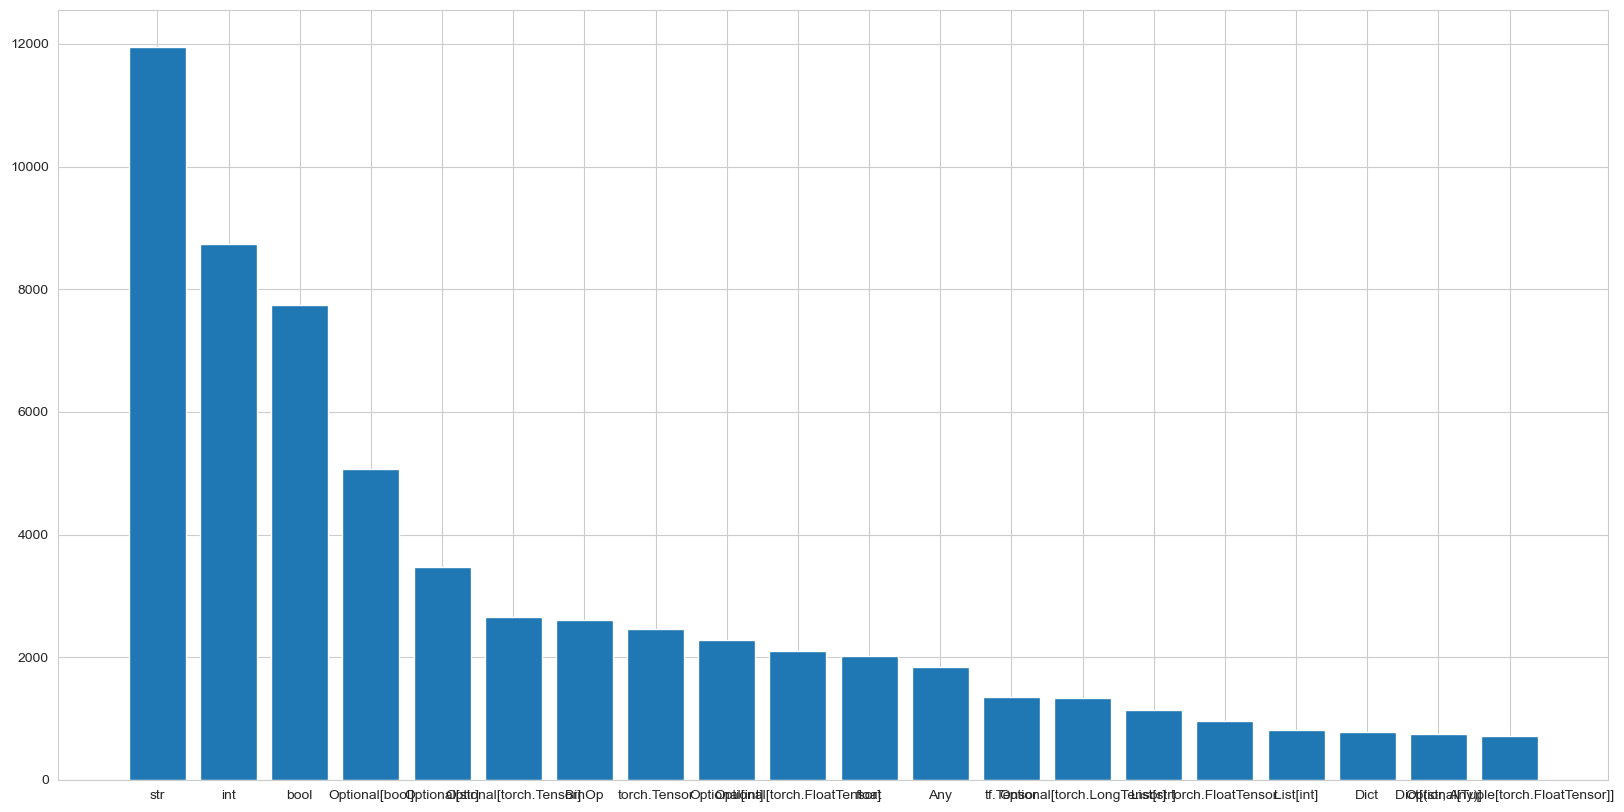

In [5]:

print(f"Amount of indices: {len(all_labels_indices_map)}")
print(f"Amount of indices with only 1 occurence: {len([ label for label, count in counted_map_of_labels.items() if count == 1 ])}")
list_of_indices = list(sorted_map_of_labels.items())
print(f"Top 10 indices have {sum([ count for label, count in list_of_indices[:10] ])} occurences")
print(f"All indices have {sum([ count for label, count in list_of_indices ])} occurences")

# Histogram for top indices
plt.figure(figsize=(20, 10))
plt.bar([ label for label, count in list_of_indices[:20] ], [ count for label, count in list_of_indices[:20] ])

### Creating a dataset and batching data

In [7]:
from torch_geometric.data import Dataset

class PythonDataset(Dataset):
    def __init__(self, datas):
        super(PythonDataset, self).__init__()
        self.datas = datas

    def len(self):
        return len(self.datas)

    def get(self, idx):
        return self.datas[idx]
    
from torch_geometric.loader import DataLoader

dataset = PythonDataset(datas)
loader = DataLoader(dataset, batch_size=1, shuffle=True)
    

In [9]:
for batch in loader:
    print(batch)

DataBatch(x=[238], edge_index=[2, 237], y=[238], batch=[238], ptr=[2])
DataBatch(x=[122], edge_index=[2, 121], y=[122], batch=[122], ptr=[2])
DataBatch(x=[848], edge_index=[2, 847], y=[848], batch=[848], ptr=[2])
DataBatch(x=[3312], edge_index=[2, 3311], y=[3312], batch=[3312], ptr=[2])
DataBatch(x=[275], edge_index=[2, 274], y=[275], batch=[275], ptr=[2])
DataBatch(x=[4203], edge_index=[2, 4202], y=[4203], batch=[4203], ptr=[2])
DataBatch(x=[623], edge_index=[2, 622], y=[623], batch=[623], ptr=[2])
DataBatch(x=[124], edge_index=[2, 123], y=[124], batch=[124], ptr=[2])
DataBatch(x=[586], edge_index=[2, 585], y=[586], batch=[586], ptr=[2])
DataBatch(x=[926], edge_index=[2, 925], y=[926], batch=[926], ptr=[2])
DataBatch(x=[424], edge_index=[2, 423], y=[424], batch=[424], ptr=[2])
DataBatch(x=[1590], edge_index=[2, 1589], y=[1590], batch=[1590], ptr=[2])
DataBatch(x=[2036], edge_index=[2, 2035], y=[2036], batch=[2036], ptr=[2])
DataBatch(x=[15], edge_index=[2, 14], y=[15], batch=[15], ptr


Learning Rate: 0.01


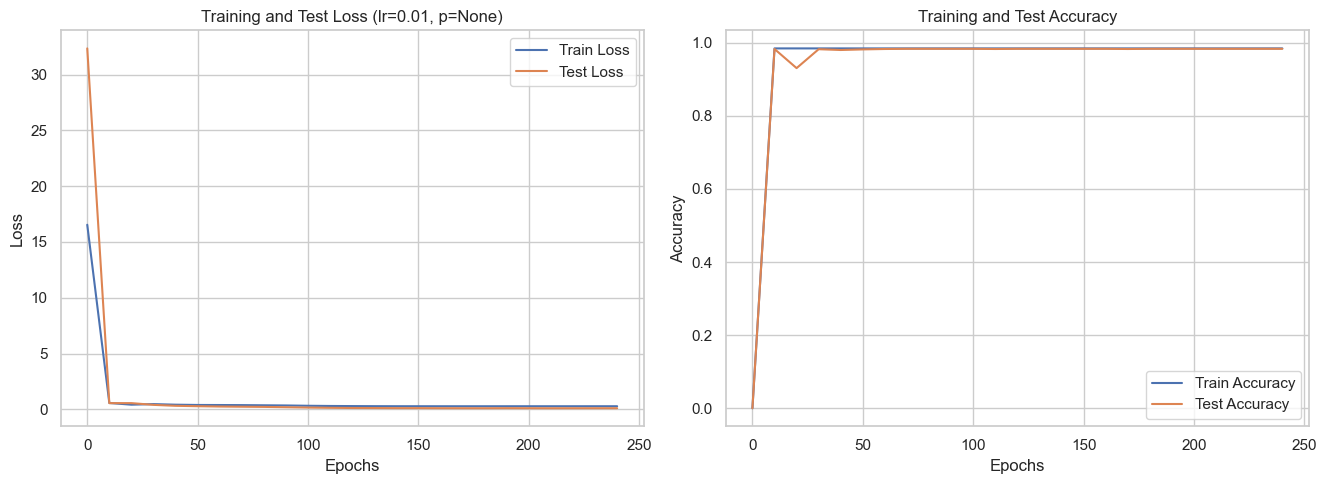


Learning Rate: 0.01


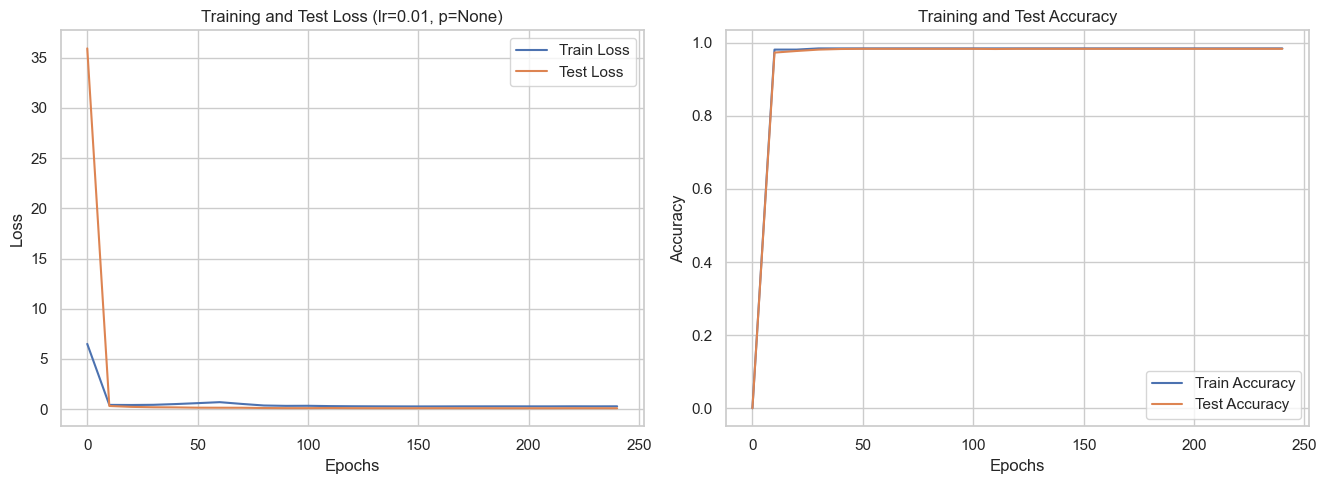


Learning Rate: 0.001


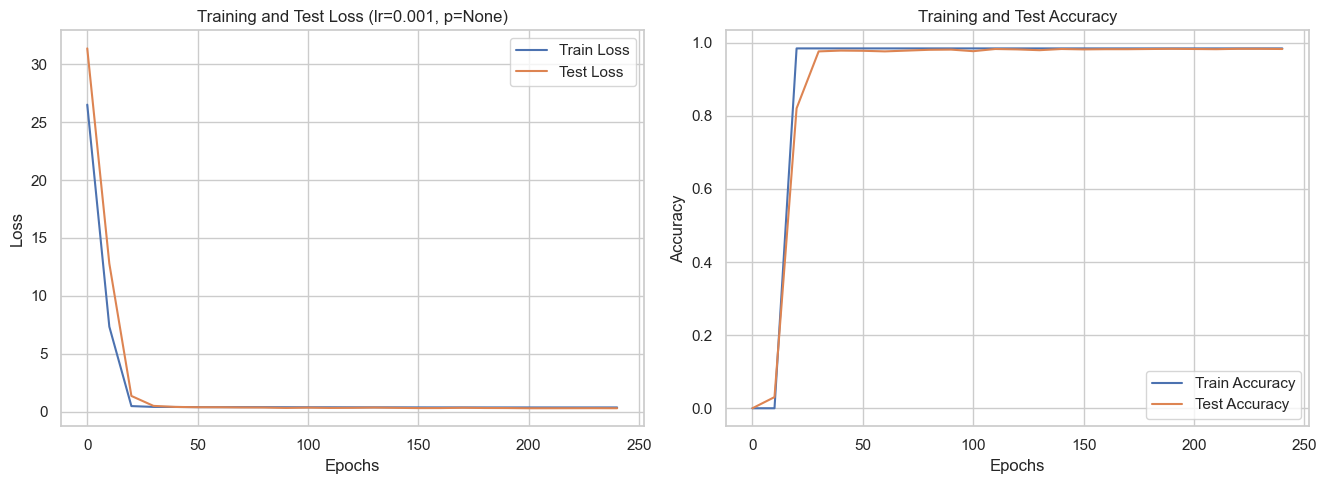


Learning Rate: 0.001


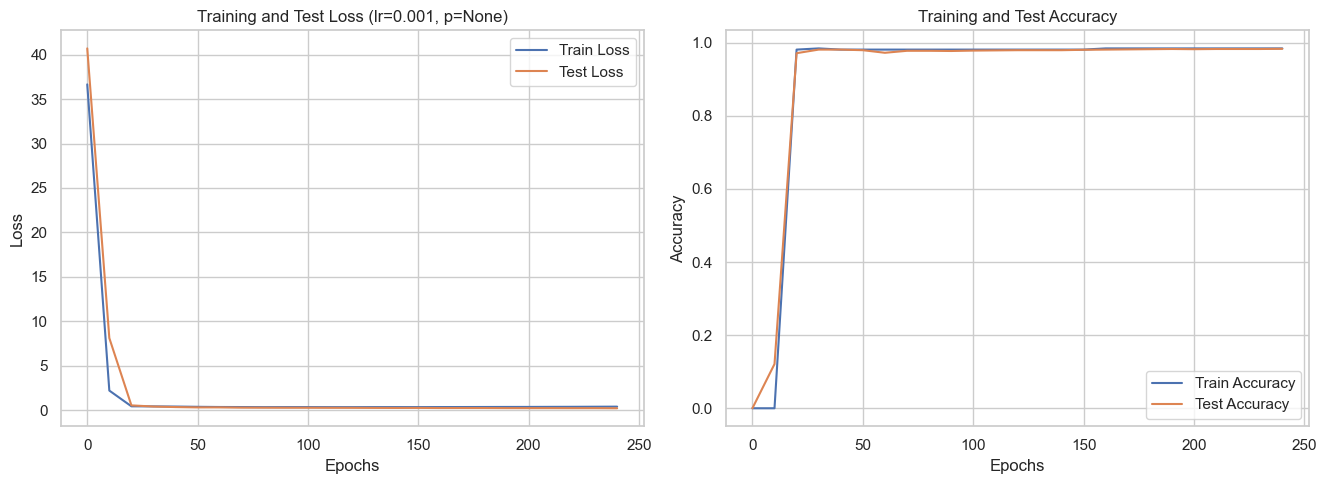

In [10]:
import start_experiment
import importlib
import torch_geometric as tg

importlib.reload(start_experiment)

data = datas[0]
data.x = data.x.view(-1, 1)
data.num_node_features = len(all_labels_indices)

transform = tg.transforms.RandomNodeSplit(split='train_rest', num_train_per_class=20, num_val=0.1, num_test=0.3)
data = transform(data)

assert data.x.shape[0] == data.y.shape[0]
assert data.edge_index.shape[0] == 2
from models.gcn import GCN

def create_model(in_channels, hidden_channels, out_channels, p, l):
    return GCN(in_channels, hidden_channels, out_channels, p, l)

data.edge_index, _ = tg.utils.add_self_loops(data.edge_index, num_nodes=data.num_nodes)

learning_rates = [0.01, 0.001]
dropouts = [0.2]
layers = [1,2]
for lr in learning_rates:
    for p in dropouts:
        for l in layers:
            model = create_model(1, 64, num_classes, p, l)
            print(f'\nLearning Rate: {lr}')
            start_experiment.start_training(model, data, 250, lr=lr, log=False)



## Node embedding (Node2Vec)

In [13]:
# Node Embeddings
from node2vec import Node2Vec
import networkx as nx

data = next(iter(results.values()))
nodes, edge_starts, edge_endings, labels = (
    data['nodes'],
    data['source_nodes'],
    data['target_nodes'],
    data['labels']
)
edge_index = torch.tensor([edge_starts, edge_endings], dtype=torch.int64)
node_types = nodes

G = nx.Graph()
edge_list = edge_index.t().tolist()  # Convert edge_index to edge list
G.add_edges_from(edge_list)

for i, node_type in enumerate(node_types):
    G.nodes[i]['type'] = node_type

node2vec = Node2Vec(G, dimensions=64, walk_length=30, num_walks=200, workers=4)

model = node2vec.fit(window=10, min_count=1, batch_words=4)

embeddings = model.wv.vectors

node_id = 0
node_embedding = model.wv[str(node_id)]

Computing transition probabilities:   0%|          | 0/3058 [00:00<?, ?it/s]

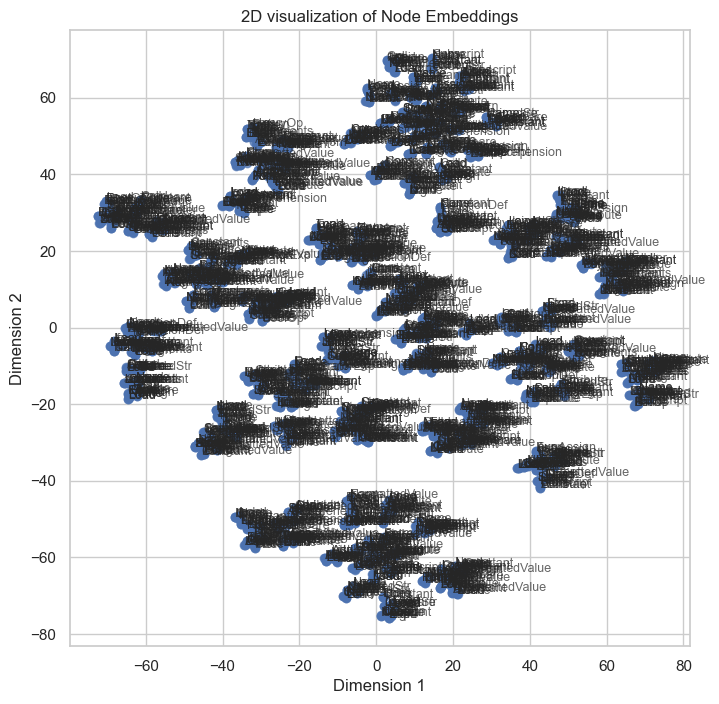

In [14]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import seaborn as sns

tsne = TSNE(n_components=2, random_state=42)
embeddings_2d = tsne.fit_transform(embeddings)  # Reduce to 2D

sns.set_theme(style="whitegrid")

plt.figure(figsize=(8, 8))
scatter = plt.scatter(embeddings_2d[:, 0], embeddings_2d[:, 1], alpha=0.7)

for i, label in enumerate(labels):
    plt.annotate(nodes[i], (embeddings_2d[i, 0], embeddings_2d[i, 1]), fontsize=9, alpha=0.7)

plt.title('2D visualization of Node Embeddings')
plt.xlabel('Dimension 1')
plt.ylabel('Dimension 2')

plt.show()

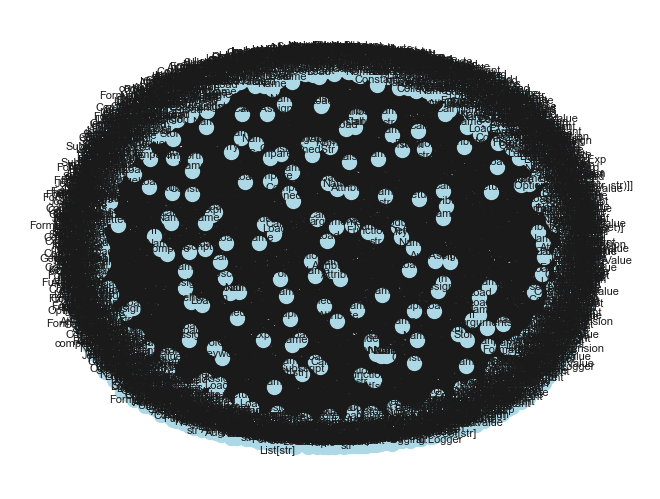

In [15]:
x = torch.tensor([nodes.index(node) for node in nodes], dtype=torch.long)

data = torch_geometric.data.Data(x=x, edge_index=torch.tensor([edge_starts, edge_endings]))
g = torch_geometric.utils.to_networkx(data, to_undirected=True)

pos = nx.spring_layout(g, k=0.7)

nx.draw(g, pos, with_labels=False, node_color='lightblue', font_weight='bold', node_size=100)
node_labels = {i: "{}\n{}".format(label, labels[i] or '') for i, label in enumerate(nodes)}
nx.draw_networkx_labels(g, pos, labels=node_labels, font_size=8)

plt.show()

In [ ]:
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()
y_train = [ label for result in results.values() for label in result['labels'] if label ]
y_train_encoded = label_encoder.fit_transform(y_train)
y_train_encoded

In [ ]:
from sklearn.linear_model import LogisticRegression
import numpy as np

node_ids = range(len(model.wv))

node_ids_train = node_ids[:int(len(node_ids) * 0.8)]
node_ids_test = node_ids[int(len(node_ids) * 0.8):]

X_train = np.array([model.wv[str(node_id)] for node_id in node_ids_train])
y_train = y_train_encoded[node_ids_train]

clf = LogisticRegression()
clf.fit(X_train, y_train)

X_test = np.array([model.wv[str(node_id)] for node_id in node_ids_test])
y_test = y_train_encoded[node_ids_test]

y_pred = clf.predict(X_test)
from sklearn.metrics import accuracy_score

accuracy_score(y_test, y_pred)